In [4]:
import pandas as pd
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


import numpy as np
warnings.filterwarnings("ignore", category=UserWarning)

# Load the dfset
df = pd.read_csv('AEP_hourly.csv')

# Convert 'Datetime' column to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])
# Sort the dfframe by datetime (if needed)
df = df.sort_values('Datetime')

# Display the first few rows of the dfset
print(df.head())
data = df.copy()


                Datetime   AEP_MW
2183 2004-10-01 01:00:00  12379.0
2184 2004-10-01 02:00:00  11935.0
2185 2004-10-01 03:00:00  11692.0
2186 2004-10-01 04:00:00  11597.0
2187 2004-10-01 05:00:00  11681.0


In [5]:

from sklearn.preprocessing import MinMaxScaler

# Normalize 'PJME_MW' using Min-Max scaling
scaler = MinMaxScaler()


In [6]:
# Assuming df contains the time series data with column 'AEP_MW'
data = df['AEP_MW'].values.reshape(-1, 1)  # Reshape to 2D array (n_samples, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create supervised dataset for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])  # Look back window
        Y.append(data[i + look_back, 0])      # Next value after look back window
    return np.array(X), np.array(Y)

# Create supervised dataset with specified look back
look_back = 24  # Number of previous hours to consider
X, Y = create_dataset(data_scaled, look_back)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]


In [7]:
# Function to create LSTM model
def create_lstm_model(neurons=50):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create LSTM model
model = create_lstm_model(neurons=50)

# Fit the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1, validation_split=0.1)


Epoch 1/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0087 - val_loss: 5.4061e-04
Epoch 2/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 6.4637e-04 - val_loss: 6.1191e-04
Epoch 3/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 4.5840e-04 - val_loss: 3.3381e-04
Epoch 4/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 3.8315e-04 - val_loss: 2.7032e-04
Epoch 5/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 3.3806e-04 - val_loss: 2.8163e-04
Epoch 6/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 3.4965e-04 - val_loss: 2.5274e-04
Epoch 7/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 3.2731e-04 - val_loss: 3.2576e-04
Epoch 8/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 2.9210e-04 - val_loss: 2.2032e-04
Epoch 9/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2.8205e-04 - val_loss: 2.5460e-04
Epoch 10/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 2.6202e-04 - val_loss: 2.4561e-04
Epoch 11/100
1365/1365 ━━━━━━━━

3032/3032 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
758/758 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train RMSE: 148.44107417603925
Test RMSE: 156.21078579298418


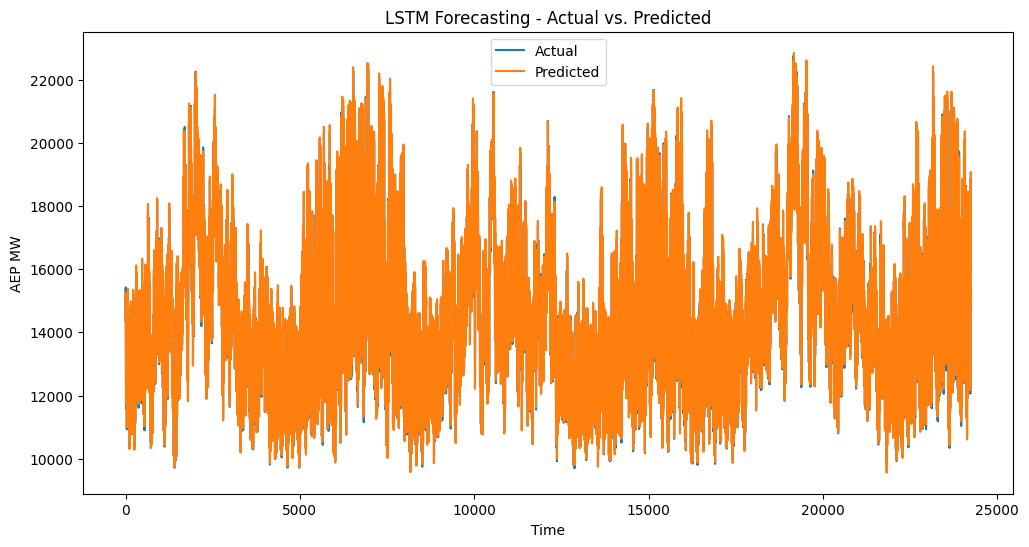

In [8]:
# Use the trained model to make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train_orig = scaler.inverse_transform(Y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
Y_test_orig = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate RMSE for training set and test set
train_rmse = np.sqrt(mean_squared_error(Y_train_orig, train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test_orig, test_predict))
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# Plot actual vs. predicted values for test set
plt.figure(figsize=(12, 6))
plt.plot(Y_test_orig, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.xlabel('Time')
plt.ylabel('AEP MW')
plt.title('LSTM Forecasting - Actual vs. Predicted')
plt.legend()
plt.show()
